# Developing a Neural Style Transfer Project from Scratch


In [ ]:
# !pip3 install pillow
# !pip install tensorflow_hub
# !pip install opencv-python-headless
!pip install matplotlib

     |██                              | 665 kB 20.4 MB/s eta 0:00:01

     |██▋                             | 931 kB 20.4 MB/s eta 0:00:01

     |██████                          | 2.1 MB 20.4 MB/s eta 0:00:01

     |███████▎                        | 2.5 MB 20.4 MB/s eta 0:00:01

     |████████▌                       | 3.0 MB 20.4 MB/s eta 0:00:01

     |███████████▏                    | 3.9 MB 20.4 MB/s eta 0:00:01

     |██████████████                  | 4.9 MB 20.4 MB/s eta 0:00:01

     |███████████████▉                | 5.6 MB 20.4 MB/s eta 0:00:01

     |██████████████████▋             | 6.6 MB 20.4 MB/s eta 0:00:01

     |█████████████████████▉          | 7.7 MB 20.4 MB/s eta 0:00:01

     |███████████████████████▉        | 8.4 MB 20.4 MB/s eta 0:00:01

     |█████████████████████████▎      | 8.9 MB 20.4 MB/s eta 0:00:01

     |█████████████████████████▉      | 9.1 MB 20.4 MB/s eta 0:00:01

     |███████████████████████████     | 9.5 MB 20.4 MB/s eta 0:00:01

     |██████████████████████████████▍ | 10.7 MB 20.4 MB/s eta 0:00:01

     |████████████████████████████████| 11.2 MB 20.4 MB/s eta 0:00:01

     |████████████████████████████████| 11.3 MB 20.4 MB/s 


     |█████████████████▏              | 624 kB 25.7 MB/s eta 0:00:01

     |████████████████████████████████| 1.2 MB 25.7 MB/s 


     |████████████████████████████████| 884 kB 28.5 MB/s 


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import numpy as np

In [ ]:
from PIL import Image

In [ ]:
base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
def gram_matrix(x):
	# The gram matrix of an image tensor (feature-wise outer product)
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
    
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
    
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))
    
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

2021-12-06 23:58:42.374047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2021-12-06 23:58:42.387761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:58:42.389380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:58:42.392607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:58:42.393907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:58:42.395157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

   16384/80134624 [..............................] - ETA: 6s

  819200/80134624 [..............................] - ETA: 4s

 1998848/80134624 [..............................] - ETA: 3s

 2473984/80134624 [..............................] - ETA: 4s

 4374528/80134624 [>.............................] - ETA: 3s

 5570560/80134624 [=>............................] - ETA: 3s

 6774784/80134624 [=>............................] - ETA: 3s

 7962624/80134624 [=>............................] - ETA: 3s

 9158656/80134624 [==>...........................] - ETA: 3s

10354688/80134624 [==>...........................] - ETA: 3s

11567104/80134624 [===>..........................] - ETA: 2s

12763136/80134624 [===>..........................] - ETA: 2s

13959168/80134624 [====>.........................] - ETA: 2s

15171584/80134624 [====>.........................] - ETA: 2s

16359424/80134624 [=====>........................] - ETA: 2s

17547264/80134624 [=====>........................] - ETA: 2s

18743296/80134624 [======>.......................] - ETA: 2s

19873792/80134624 [======>.......................] - ETA: 2s

21512192/80134624 [=======>......................] - ETA: 2s

22609920/80134624 [=======>......................] - ETA: 2s

24051712/80134624 [========>.....................] - ETA: 2s

25247744/80134624 [========>.....................] - ETA: 2s

25919488/80134624 [========>.....................] - ETA: 2s

27721728/80134624 [=========>....................] - ETA: 2s

28934144/80134624 [=========>....................] - ETA: 2s

30146560/80134624 [==========>...................] - ETA: 2s

31342592/80134624 [==========>...................] - ETA: 2s

32538624/80134624 [===========>..................] - ETA: 2s

33734656/80134624 [===========>..................] - ETA: 1s

34947072/80134624 [============>.................] - ETA: 1s

36143104/80134624 [============>.................] - ETA: 1s

37355520/80134624 [============>.................] - ETA: 1s

38551552/80134624 [=============>................] - ETA: 1s

39747584/80134624 [=============>................] - ETA: 1s

40943616/80134624 [==============>...............] - ETA: 1s

42139648/80134624 [==============>...............] - ETA: 1s

43352064/80134624 [===============>..............] - ETA: 1s

44548096/80134624 [===============>..............] - ETA: 1s

45744128/80134624 [================>.............] - ETA: 1s

46940160/80134624 [================>.............] - ETA: 1s

48136192/80134624 [=================>............] - ETA: 1s

49332224/80134624 [=================>............] - ETA: 1s

50528256/80134624 [=================>............] - ETA: 1s

51724288/80134624 [==================>...........] - ETA: 1s

52920320/80134624 [==================>...........] - ETA: 1s

54132736/80134624 [===================>..........] - ETA: 1s

55328768/80134624 [===================>..........] - ETA: 1s

56524800/80134624 [====================>.........] - ETA: 0s

57720832/80134624 [====================>.........] - ETA: 0s

58916864/80134624 [=====================>........] - ETA: 0s

60112896/80134624 [=====================>........] - ETA: 0s

61317120/80134624 [=====================>........] - ETA: 0s

62504960/80134624 [======================>.......] - ETA: 0s

63700992/80134624 [======================>.......] - ETA: 0s

64897024/80134624 [=======================>......] - ETA: 0s

66109440/80134624 [=======================>......] - ETA: 0s

67321856/80134624 [========================>.....] - ETA: 0s

68517888/80134624 [========================>.....] - ETA: 0s

69713920/80134624 [=========================>....] - ETA: 0s

70909952/80134624 [=========================>....] - ETA: 0s

72105984/80134624 [=========================>....] - ETA: 0s

73302016/80134624 [==========================>...] - ETA: 0s

74514432/80134624 [==========================>...] - ETA: 0s

75710464/80134624 [===========================>..] - ETA: 0s

76914688/80134624 [===========================>..] - ETA: 0s

78118912/80134624 [============================>.] - ETA: 0s

79314944/80134624 [============================>.] - ETA: 0s

80142336/80134624 [==============================] - 3s 0us/step


80150528/80134624 [==============================] - 3s 0us/step


In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads
    
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 2000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

2021-12-06 23:58:58.646065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2021-12-06 23:59:00.458770: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


Iteration 100: loss=11018.03


Iteration 200: loss=8514.29


Iteration 300: loss=7571.87


Iteration 400: loss=7063.99


Iteration 500: loss=6735.79


Iteration 600: loss=6501.30


Iteration 700: loss=6322.90


Iteration 800: loss=6181.11


Iteration 900: loss=6064.88


Iteration 1000: loss=5967.31


Iteration 1100: loss=5884.28


Iteration 1200: loss=5812.66


Iteration 1300: loss=5750.40


Iteration 1400: loss=5695.75


Iteration 1500: loss=5647.35


Iteration 1600: loss=5604.33


Iteration 1700: loss=5565.67


Iteration 1800: loss=5530.77


Iteration 1900: loss=5499.15


Iteration 2000: loss=5470.41


# Developing Neural Style transfer with TensorFlow Hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
# Access the pre-trained model from TensorFlow-Hub

model_link = "https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"
NST_model = hub.load(model_link)

In [ ]:
# Function to load and operate on the content and style images

def get_data(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [ ]:
content_image = get_data('bridge.jfif')
style_image = get_data('starry night.jpeg')

In [ ]:
generated_image = NST_model(tf.constant(content_image), tf.constant(style_image))[0]

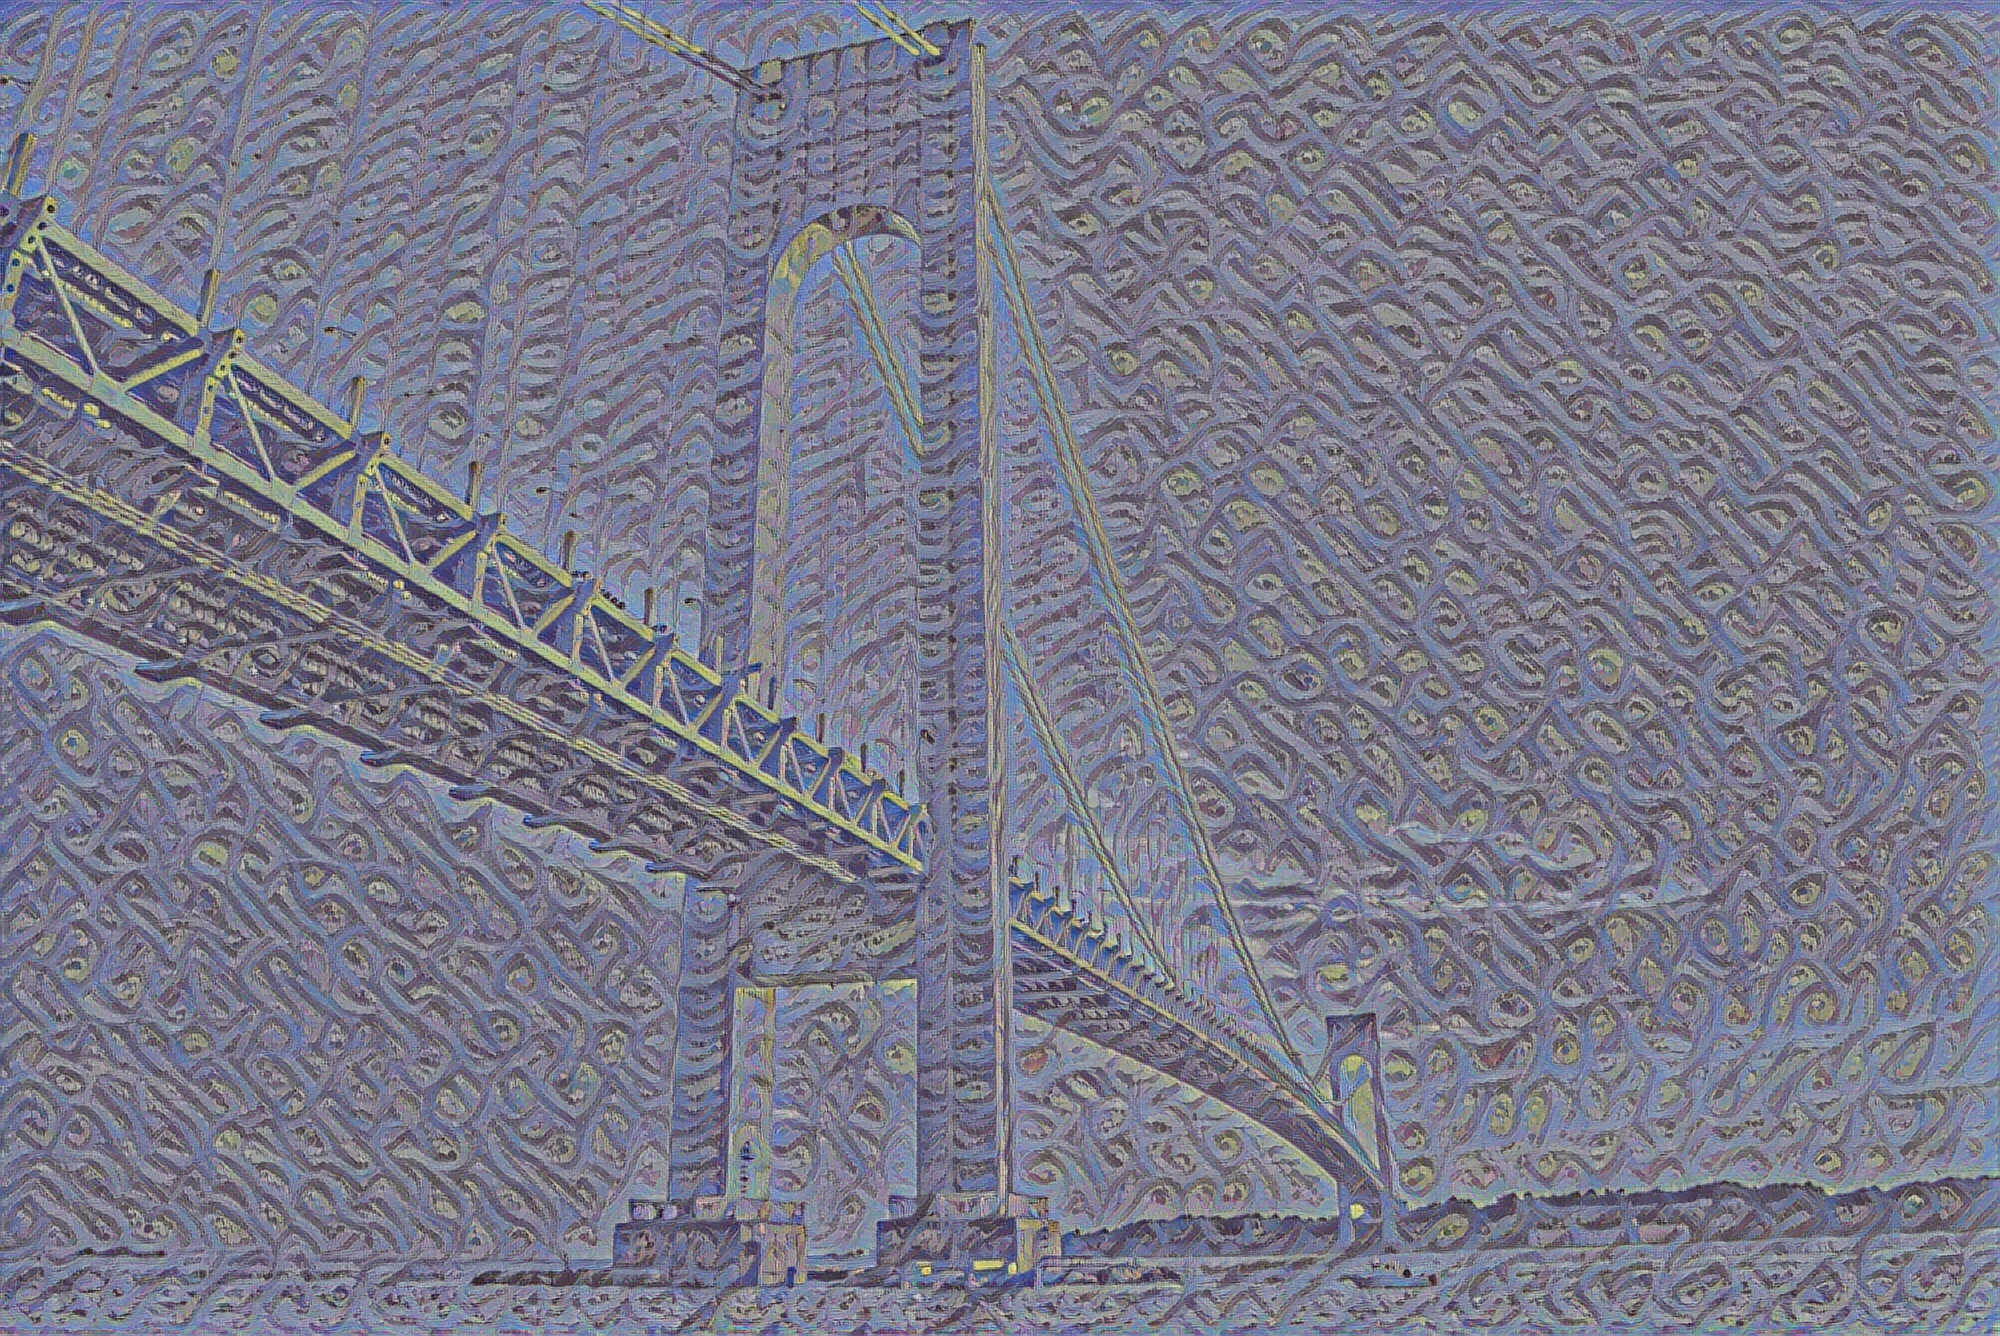

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)
tensor_to_image(generated_image)